# DAB200 -- Lab 5

In this lab, you will gain further experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric, as well as, exploring ways to increase model performance through data set improvement.

**Target**: `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1-3 | vehicles_2014.csv |
| 4-6 | vehicles_2015.csv |
| 7-9 | vehicles_2016.csv |
| 10-12 | vehicles_2017.csv |
| 13-15 | vehicles_2018.csv |
| 16-18 | vehicles_2019.csv |

**Important Notes:**
- **Only provide FINAL code in each Part of the lab**
    - I only want to see final, well-organized code in your submission
- Only need to use **random forest** models
    - All random forest models should include 150 decision trees
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
     - **If you use `train_test_split()` or calculate MSE or MAE you will have marks deducted!**
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective
- Don't make assumptions!
- Information about the data can be found at [this website](https://www.fueleconomy.gov/feg/download.shtml)



**A few tips**
 - The function `sniff_modified` (from lecture notebooks) will probably come in handy
 - If you use `dropna`, it may be worthwhile exloring the `thresh` parameter
 - If you use `.info()`, you might need to set the `verbose` parameter
 - List comprehensions (or other programmatic methods) might be helpful in trying to select columns: `[f for f in df.columns if 'some_text' in f]`
 - And you don't have to get all the columns of interest in one go because `['a', 'b'] + ['c', 'd'] = ['a', 'b', 'c', 'd']`
 - If a feature has only 1 unique element how long would the list `df[col].unique()` be?
 - To help in viewing the data, you may find these commands helpful (see [here](https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/) for explanation):
    - `pd.set_option('display.max_rows', None)`
    - `pd.set_option('display.max_columns', None)`
    - `pd.set_option('display.width', None)`
    - `pd.set_option('display.max_colwidth', None)`
 - start simple; then build up complexity, but only if needed

### Part 0

Please provide the following information by editing this cell:
 - Group Number: 17 
 - Group Members: Aashutosh Sehgal (0780170), Saheb Singh Bhatia (0781209)     

### Part 1: Initial data clean-up

In this part, you will follow the steps below to do an initial clean-up of the data.

##### Step 1: Remove target related features

The data contains some features that are essentially equivalent to the target. If we leave them in, they will leak information about the target to the model and the model performance will be erroneously high. Columns with a date are also not helpful here. In this step, we will remove any feature that contains:
 - 'rating'
 - 'ghg'
 - 'mpg'
 - 'co2'
 - 'alternative fuel'
 - 'conventional fuel' (except for the actual target!)
 - 'fuel costs'
 - 'date'

There may be other columns that are strongly correlated with the target that **need to be removed**; so, if you are getting a very high oob score (approx. = 1) then you should check for other features that may also be equivalent to the target and remove them also. 

In [147]:
# Importing all libraries and reading data from csv file.
# Using info() method to look at columns, their datatypes and NULL vales etc.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from pandas.api.types import is_string_dtype, is_object_dtype
import category_encoders as ce
from rfpimp import *

veh_raw = pd.read_csv('vehicles_2019.csv')

In [148]:
veh_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 162 columns):
 #    Column                                                                                                     Dtype  
---   ------                                                                                                     -----  
 0    Model Year                                                                                                 int64  
 1    Mfr Name                                                                                                   object 
 2    Division                                                                                                   object 
 3    Carline                                                                                                    object 
 4    Verify Mfr Cd                                                                                              object 
 5    Index (Model Type Index)               

In [149]:
veh_raw.columns= veh_raw.columns.str.lower()

In [150]:
num = 0
non_num = 0
for col in veh_raw.columns:
    if is_string_dtype(veh_raw[col]) or is_object_dtype(veh_raw[col]):
        non_num += 1
    elif veh_raw[col].dtypes=='int64' or veh_raw[col].dtypes=='float64':
        num +=1
print(num)
print(non_num)

96
66


In [151]:
drop_cols_text = ('rating','ghg','mpg','co2','alternative fuel','conventional fuel','fuel costs','date')

In [152]:
drop_cols = []
for col in veh_raw.columns:
    if col != 'comb unadj fe - conventional fuel':
        for text in drop_cols_text:
            if text in col:
                drop_cols.append(col)

In [153]:
drop_cols

['city fe (guide) - conventional fuel',
 'hwy fe (guide) - conventional fuel',
 'comb fe (guide) - conventional fuel',
 'city unadj fe - conventional fuel',
 'hwy unadj fe - conventional fuel',
 'city unrd adj fe - conventional fuel',
 'hwy unrd adj fe - conventional fuel',
 'comb unrd adj fe - conventional fuel',
 'range1 - model type driving range - conventional fuel',
 'fuel usage  - conventional fuel',
 'fuel usage desc - conventional fuel',
 'fuel unit - conventional fuel',
 'fuel unit desc - conventional fuel',
 'annual fuel1 cost - conventional fuel',
 'epa calculated annual fuel cost - conventional fuel -----  annual fuel cost error. please revise verify. ',
 'city2 fe (guide) - alternative fuel',
 'hwy2 fuel fe (guide) - alternative fuel',
 'comb2 fuel fe (guide) - alternative fuel',
 'city2 unadj fe - alternative fuel',
 'hwy2 unadj fe - alternative fuel',
 'comb2 unadj fe - alternative fuel',
 'city2 unrd adj fe - alternative fuel',
 'hwy2 unrd adj fe - alternative fuel',
 '

In [154]:
veh = veh_raw.drop(columns= drop_cols)

In [155]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

##### Step 2: Remove features with $\ge$90% missing values

The data contains some features that have a lot of missing values. Remove any feature that has $\ge$90% missing values. There is nothing magical about this number. We are simply picking a starting threshold. In a real-world scenario we would probably need to revisit and justify this threshold, but for now we will use it to get started.

In [156]:
veh.dropna(axis=1, thresh=0.9*len(veh),inplace=True)

##### Step 3: Convert all string/object features to lower case

If any categorical feature contains both 'Yes' and 'yes', we want our model to treat these as the same. To do that, we need to convert all string/objet type features to lower case. (*Hint*: If you use a function for this, make sure it returns a data frame.) 

In [157]:
def to_lowercase():
    for col in veh.columns:
        if is_string_dtype(veh[col]) or is_object_dtype(veh[col]):
            veh[col] = veh[col].str.lower()
    return veh

In [158]:
veh = to_lowercase()

In [159]:
df = sniff_modified(veh)

##### Step 4: Remove any feature with only 1 unique value

If any feature contains only a single value, then our model will not be able to use this feature to help it predict our target, since there will be no pattern to discover. These features can be removed from the data. 

In [160]:
x = df[df['No. unique'] == 1].index
veh.drop(columns=x,inplace=True)

In [161]:
num = 0
non_num = 0
for col in veh.columns:
    if is_string_dtype(veh[col]) or is_object_dtype(veh[col]):
        non_num += 1
    elif veh[col].dtypes=='int64' or veh[col].dtypes=='float64':
        num +=1
print(num)
print(non_num)

10
26


##### Step 5: Compare data sets

Compare some basic characteristics between our original data set and the one after our initial clean up. Fill in the table below:

| Characteristic | Original data set | After initial clean-up |
| :- | :- | :- |  
|  # rows  |  1270   | 1270  | 
|  # columns  |  162   | 36  | 
|  # numeric features |  96   | 10  | 
|  # non-nonumeric features |  66   | 26  | 

### Part 2 - Create and evaluate an initial model

In this part you should: 
 - use the cleaned-up version of the data from **Part 1**
 - isolate all numeric features from the data set 
 - fill in any missing values with 0
 - create and evaluate a baseline model 

In [162]:
for col in veh:
    if veh[col].dtypes=='int64' or veh[col].dtypes=='float64':
        if veh[col].isnull().values.any():
            veh[col].fillna(0,inplace=True)

In [163]:
numfeatures = []
for col in veh.columns:
    if veh[col].dtypes=='int64' or veh[col].dtypes=='float64':
        numfeatures.append(col)

In [164]:
numfeatures = numfeatures[1:]

In [165]:
veh_num = veh[numfeatures]

In [166]:
X = veh_num.drop('comb unadj fe - conventional fuel', axis=1)
y = veh_num['comb unadj fe - conventional fuel']
oob_scores = []
for i in range(10):
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) 
    rf.fit(X, y)
    oob_scores.append(rf.oob_score_)

In [167]:
baseline1_oob = np.mean(oob_scores)
baseline1_oob

0.8436826877061104

In [168]:
I = importances(rf, X, y, features= list(X.columns))
I

,Importance
Feature,
eng displ,1.345428
carline class,0.295871
epa fe label dataset id,0.252993
# gears,0.249438
max ethanol % - gasoline,0.090503
# cyl,0.002647
intake valves per cyl,0.000176
exhaust valves per cyl,0.000111


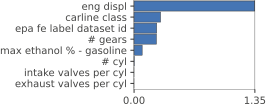

In [169]:
# Looking at feature importance plot.

plot_importances(I, color='#4575b4')

### Part 3 - Convert all features to numeric and handle missing values

In this part you should: 
 - only use ordinal encoding 
 - convert **all** non-numeric features to numeric 
 - handle any missing values in any feature
 - assume all missing data has already been normalized appropriately

In [170]:
# Sperating categorical fields.

nonnum = [col for col in veh.columns.tolist() if col not in numfeatures + ['comb unadj fe - conventional fuel']]
veh_nonnum = veh[nonnum]

In [171]:
# Looking at the unique values stored in each categorical column.

for col in veh_nonnum:
    print(veh_nonnum[col].unique())

['honda' 'fca us llc' 'aston martin' 'volkswagen group of' 'bmw'
 'general motors' 'ferrari' 'ford motor company' 'jaguar land rover l'
 'mazda' 'mercedes-benz' 'nissan' 'porsche' 'subaru' 'toyota' 'maserati'
 'roush' 'hyundai' 'kia' 'mitsubishi motors co' 'rolls-royce'
 'subaru tecnica inte' 'volvo' 'mclaren automotive']
['acura' 'alfa romeo' 'aston martin lagonda ltd' 'audi' 'bmw' 'bugatti'
 'chevrolet' 'ferrari north america, inc.' 'fiat' 'ford' 'jaguar'
 'lamborghini' 'mazda' 'mercedes-benz' 'nissan' 'porsche' 'mini' 'subaru'
 'toyota' 'buick' 'infiniti' 'lexus' 'maserati' 'roush industries, inc.'
 'volkswagen' 'cadillac' 'genesis' 'honda' 'hyundai motor company'
 'kia motors corporation' 'mitsubishi motors corporation'
 'rolls-royce motor cars limited' 'subaru tecnica international'
 'volvo cars of north america, llc' 'bentley' 'dodge' 'lincoln' 'chrysler'
 'gmc' 'ram' 'jeep' 'land rover' 'mclaren']
['nsx' '4c' 'vantage v8' 'tt roadster quattro' 'z4 sdrive30i' 'chiron'
 'corvette'

In [172]:
def ordinal_encoding_non_numeric_cols():
    X = veh
    encoder = ce.OrdinalEncoder(cols=nonnum)
    encoder.fit(X)
    X = encoder.transform(X)
    return X

In [173]:
veh = ordinal_encoding_non_numeric_cols()

In [174]:
for col in veh:
    if col in veh_num:
        if veh[col].isnull().values.any():
            veh[col].fillna(0,inplace=True)
    else:
        veh[col].fillna(veh[col].median(),inplace=True)

In [175]:
veh_nonnum.nunique()

mfr name                                                                24
division                                                                43
carline                                                                846
verify mfr cd                                                           24
index (model type index)                                               510
transmission                                                            27
air aspiration method desc                                               5
trans                                                                    7
trans desc                                                               7
lockup torque converter                                                  2
trans creeper gear                                                       2
drive sys                                                                5
drive desc                                                               5
gas guzzler exempt (where

### Part 4 - Create and evaluate a new baseline

In this part you should:
 - create and evaluate a model using all the features, that is, after converting everything to numeric and handling missing values

In [176]:
X = veh.drop('comb unadj fe - conventional fuel', axis=1)
y = veh['comb unadj fe - conventional fuel']
oob_scores = []
for i in range(10):
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) 
    rf.fit(X, y)
    oob_scores.append(rf.oob_score_)

In [177]:
baseline2_oob = np.mean(oob_scores)
baseline2_oob

0.9353954160586812

In [178]:
I = importances(rf, X, y, features= list(X.columns))
I

,Importance
Feature,
eng displ,1.158370
transmission,0.076432
carline,0.056604
trans desc,0.048318
stop/start system (engine management system) description,0.040685
trans,0.040063
stop/start system (engine management system) code,0.022386
# gears,0.016265
oil viscosity,0.013949


C:\Users\aashu\anaconda3\envs\DAB200\lib\site-packages\rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


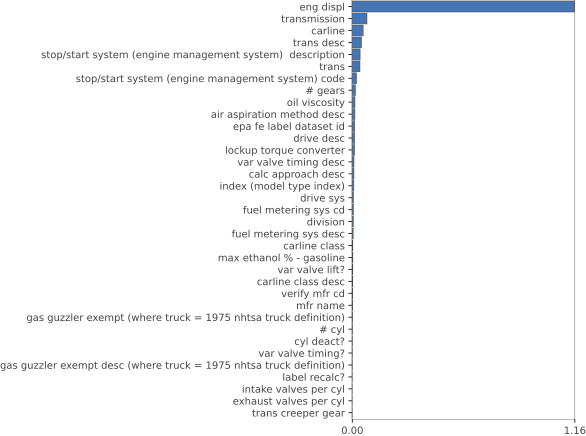

In [179]:
# Looking at feature importance plot.

plot_importances(I, color='#4575b4')

**Question** Did the performance of the model improve compared to the results of **Part 2**?

In [180]:
((baseline2_oob-baseline1_oob)/baseline2_oob)*100

9.804701496080156

As we can see from above the performance of model improved by 9.73%.

### Part 5 - How high can you go?

How high can you get the oob score above the new baseline of **Part 4**? See how much improvement you can squeeze out of the data. 

**For this part, do NOT do any hyper-parameter tuning.**

Some things to try to get started:
 - are some features not important so can be dropped without impacting performance?
 - do other encodings work better than ordinal for some features?  
 - any feature engineering that will help? 
 - any external data that could be included? 

### Removing columns and using one hot encoder on varibales with less than 10 unique values.

In [181]:
del veh['intake valves per cyl']
del veh['exhaust valves per cyl']
del veh['trans creeper gear']

In [182]:
for col in veh_nonnum:
    print(veh_nonnum[col].unique())

['honda' 'fca us llc' 'aston martin' 'volkswagen group of' 'bmw'
 'general motors' 'ferrari' 'ford motor company' 'jaguar land rover l'
 'mazda' 'mercedes-benz' 'nissan' 'porsche' 'subaru' 'toyota' 'maserati'
 'roush' 'hyundai' 'kia' 'mitsubishi motors co' 'rolls-royce'
 'subaru tecnica inte' 'volvo' 'mclaren automotive']
['acura' 'alfa romeo' 'aston martin lagonda ltd' 'audi' 'bmw' 'bugatti'
 'chevrolet' 'ferrari north america, inc.' 'fiat' 'ford' 'jaguar'
 'lamborghini' 'mazda' 'mercedes-benz' 'nissan' 'porsche' 'mini' 'subaru'
 'toyota' 'buick' 'infiniti' 'lexus' 'maserati' 'roush industries, inc.'
 'volkswagen' 'cadillac' 'genesis' 'honda' 'hyundai motor company'
 'kia motors corporation' 'mitsubishi motors corporation'
 'rolls-royce motor cars limited' 'subaru tecnica international'
 'volvo cars of north america, llc' 'bentley' 'dodge' 'lincoln' 'chrysler'
 'gmc' 'ram' 'jeep' 'land rover' 'mclaren']
['nsx' '4c' 'vantage v8' 'tt roadster quattro' 'z4 sdrive30i' 'chiron'
 'corvette'

In [183]:
def seperate_categorical():
    onehot = []
    ordinal = []
    for col in veh_nonnum:
        if col!="trans creeper gear":
            if veh_nonnum[col].nunique() < 10:
                onehot.append(col)
            else:
                ordinal.append(col)
    return onehot,ordinal

In [184]:
onehot,ordinal = seperate_categorical()

In [185]:
onehot

['air aspiration method desc',
 'trans',
 'trans desc',
 'lockup torque converter',
 'drive sys',
 'drive desc',
 'gas guzzler exempt (where truck = 1975 nhtsa truck definition)',
 'gas guzzler exempt desc (where truck = 1975 nhtsa truck definition)',
 'calc approach desc',
 'label recalc?',
 'cyl deact?',
 'var valve timing?',
 'var valve lift?',
 'fuel metering sys cd',
 'fuel metering sys desc',
 'stop/start system (engine management system) code',
 'stop/start system (engine management system)  description']

In [186]:
ordinal

['mfr name',
 'division',
 'carline',
 'verify mfr cd',
 'index (model type index)',
 'transmission',
 'carline class desc',
 'var valve timing desc',
 'oil viscosity']

In [187]:
for col in onehot:
    veh[col].fillna("",inplace=True) 

In [188]:
for col in ordinal:
    veh[col].fillna("",inplace=True) 

In [189]:
def ordinal_encoding():
    X = veh
    encoder = ce.OrdinalEncoder(cols=ordinal)
    encoder.fit(X)
    X = encoder.transform(X)
    return X

In [190]:
def onehot_encoding():
    X = veh
    encoder = ce.OneHotEncoder(cols=onehot)
    encoder.fit(X)
    X = encoder.transform(X)
    return X

In [191]:
veh = ordinal_encoding()

In [192]:
veh = onehot_encoding()

In [193]:
for col in veh:
    if col in veh_num:
        if veh[col].isnull().values.any():
            veh[col].fillna(0,inplace=True)
    else:
        veh[col].fillna(veh[col].median(),inplace=True)

In [194]:
# Splitting the dataset into training and testing.
# Creating empty list to append values of the OOB Scores.

def estimate_mean_oob_score_final():
    X = veh.drop('comb unadj fe - conventional fuel', axis=1)
    y = veh['comb unadj fe - conventional fuel']
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) 
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    return np.mean(oob_scores)

In [195]:
score1 = estimate_mean_oob_score_final()

In [196]:
score_improved1 = score1 - baseline2_oob 
score_improved1

0.004609531271102196

### Using log of target varibale.

In [197]:
# Splitting the dataset into training and testing.
# Creating empty list to append values of the OOB Scores.

def estimate_mean_oob_score_final():
    X = veh.drop('comb unadj fe - conventional fuel', axis=1)
    y = veh['comb unadj fe - conventional fuel']
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) 
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    return np.mean(oob_scores)

In [198]:
score2 = estimate_mean_oob_score_final()

In [199]:
score_improved2 = score2 - baseline2_oob 
score_improved2

0.004192714507209372

### Part 6 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using only the features that give the best results after the exploration done in Part 4 

In [200]:
# Splitting the dataset into training and testing.
# Creating empty list to append values of the OOB Scores.

def estimate_mean_oob_score_final():
    X = veh.drop('comb unadj fe - conventional fuel', axis=1)
    y = veh['comb unadj fe - conventional fuel']
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, oob_score=True) 
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    return np.mean(oob_scores)

In [201]:
final_oob = estimate_mean_oob_score_final()
final_oob

0.9407184471256536

### Part 7 - How did you do?

**Question** What is the percent difference between the oob score of your best model and the baseline calculated in **Part 4**?

In [203]:
((final_oob - baseline2_oob)/final_oob)*100

0.5658474204728121

The percentage difference between part 4 oob score and final oob score is 0.566%.

**Question** What changes did you make to the data set of **Part 4** to get to the final data set used in **Part 6** and how much did each change increase the oob score that you calculated in **Part 4**? 

**Enter your answer here:**

| Change made | Change in oob score | 
| :- | :-: |  
|  Removing columns and using one-hot encoder on varibales with less than 10 unique values.  | +0.0044    | 
|  Using log of target varibale.  | +0.0043    | 